# Why Implicit ratings?

Explicit recommenders tend to focus on the gathered information – those user-item pairs that we know their ratings – which provide a balanced picture on the user preference. Thus, the remaining useritem relationships, which typically constitute the vast majority of the data, are treated as “missing data” and are omitted from the analysis. This is impossible with implicit feedback, as concentrating only on the gathered feedback will leave us with the positive feedback, greatly misrepresenting the full user profile. Hence, it is crucial to address also the missing data, which is where most negative feedback is expected to be found.

# Setup

In [1]:
import sys
sys.path.insert(0, '../src')
import preprocess
import utils
import random
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
import implicit
import codecs
import json

In [3]:
def generate_implicit_data(debug=False, datadir='../dblp-ref'):
    # Note that this is not train-test split. This is just entire data. 
    # (skipping papers which have 0 citation)
    if debug:
        DBLP_LIST = [ datadir+'/dblp-ref-3.json' ]
        saveFilename = 'aminer-debug.tsv'
    else:
        DBLP_LIST = [ datadir+'/dblp-ref-0.json',
        datadir+'/dblp-ref-1.json',
        datadir+'/dblp-ref-2.json',
        datadir+'/dblp-ref-3.json' ]
        saveFilename = 'aminer-full.tsv'
        
    with codecs.open(datadir+'/'+saveFilename, "w", "utf8") as o:
        for each_file in DBLP_LIST:
            with open(each_file) as f:
                line = f.readline()
                while line:
                    data = json.loads(line)
                    try:
                        for ref in data["references"]:
                            o.write("%s\t%s\t%s\n" % (data["id"], ref, 1))
                    except KeyError:
                        pass
                    line = f.readline()

In [8]:
generate_implicit_data(True)

In [ ]:
generate_implicit_data()

# Implicit

In [16]:
import argparse
import codecs
import logging
import time

import numpy
import pandas
from scipy.sparse import coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

# maps command line model argument to class name
MODELS = {"als":  AlternatingLeastSquares,
          "nmslib_als": NMSLibAlternatingLeastSquares,
          "annoy_als": AnnoyAlternatingLeastSquares,
          "faiss_als": FaissAlternatingLeastSquares,
          "tfidf": TFIDFRecommender,
          "cosine": CosineRecommender,
          "bpr": BayesianPersonalizedRanking,
          "bm25": BM25Recommender}


def get_model(model_name):
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if issubclass(model_class, AlternatingLeastSquares):
        params = {'factors': 64, 'dtype': numpy.float32, 'use_gpu': False}
    elif model_name == "bm25":
        params = {'K1': 100, 'B': 0.5}
    elif model_name == "bpr":
        params = {'factors': 63, 'use_gpu': False}
    else:
        params = {}

    return model_class(**params)


def read_data(filename):
    """ Reads in the AMINER dataset, and returns a tuple of a pandas dataframe
    and a sparse matrix of artist/user/playcount """
    # read in triples of user/artist/playcount from the input dataset
    # get a model based off the input params
    start = time.time()
    print("reading data from %s"% (filename))
    data = pandas.read_table(filename,
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'cites'],
                             na_filter=False)

    # map each artist and user to a unique numeric value
    data['user'] = data['user'].astype("category")
    data['ref'] = data['ref'].astype("category")

    # create a sparse matrix of all the users/plays
    cites = coo_matrix((data['cites'].astype(numpy.float32),
                       (data['ref'].cat.codes.copy(),
                        data['user'].cat.codes.copy())))

    print("read data file in {}".format( time.time() - start))
    return data, cites

'''
def calculate_similar_artists(input_filename, output_filename, model_name="als"):
    """ generates a list of similar artists in lastfm by utiliizing the 'similar_items'
    api of the models """
    df, plays = read_data(input_filename)

    # create a model from the input data
    model = get_model(model_name)

    # if we're training an ALS based model, weight input for last.fm
    # by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        plays = bm25_weight(plays, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_recommend = False

    # this is actually disturbingly expensive:
    plays = plays.tocsr()

    print("training model {}".format( model_name))
    start = time.time()
    model.fit(plays)
    print("trained model '%s' in %0.2f"%( model_name, time.time() - start))

    # write out similar artists by popularity
    artists = dict(enumerate(df['artist'].cat.categories))
    start = time.time()
    print("calculating top artists")
    user_count = df.groupby('artist').size()
    to_generate = sorted(list(artists), key=lambda x: -user_count[x])

    # write out as a TSV of artistid, otherartistid, score
    with codecs.open(output_filename, "w", "utf8") as o:
        for artistid in to_generate:
            artist = artists[artistid]
            for other, score in model.similar_items(artistid, 11):
                o.write("%s\t%s\t%s\n" % (artist, artists[other], score))

    print("generated similar artists in %0.2f"%(time.time() - start))
'''

def calculate_recommendations(input_filename, output_filename, model_name="als"):
    """ Generates artist recommendations for each user in the dataset """
    # train the model based off input params
    df, cites = read_data(input_filename)

    # create a model from the input data
    model = get_model(model_name)

    # if we're training an ALS based model, weight input for last.fm
    # by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        cites = bm25_weight(cites, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_similar_items = False

    # this is actually disturbingly expensive:
    cites = cites.tocsr()

    print("training model {}".format(model_name))
    start = time.time()
    model.fit(cites)
    print("trained model '%s' in %0.2f"%( model_name, time.time() - start))

    # generate recommendations for each user and write out to a file
    artists = dict(enumerate(df['ref'].cat.categories))
    start = time.time()
    user_cites = cites.T.tocsr()
    with codecs.open(output_filename, "w", "utf8") as o:
        for userid, username in enumerate(df['user'].cat.categories):
            for artistid, score in model.recommend(userid, user_cites):
                o.write("%s\t%s\t%s\n" % (username, artists[artistid], score))
    print("generated recommendations in %0.2f"%(  time.time() - start))


def start(inputfile='../dblp-ref/aminer-debug.tsv',outputfile='../output-debug.tsv', model='als'):

    #if recommend:
    calculate_recommendations(inputfile, outputfile, model_name=model)
    #else:
        #calculate_similar_artists(inputfile, outputfile, model_name=model)
       

In [15]:
!export OPENBLAS_NUM_THREADS=1
!export MKL_NUM_THREADS=1

start()

reading data from ../dblp-ref/aminer-debug.tsv


read data file in 1.4693903923034668
weighting matrix by bm25_weight
training model als
trained model 'als' in 7.02
generated recommendations in 385.65


# Result

If we use threshold of 0.1, we generated a total of 18603 recommendations for 47018 papers

In [3]:
visData = pd.read_table('../output-debug.tsv',
                             usecols=[0, 1, 2],
                             names=['user', 'ref', 'score'],
                             na_filter=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb11e730d30>]], dtype=object)

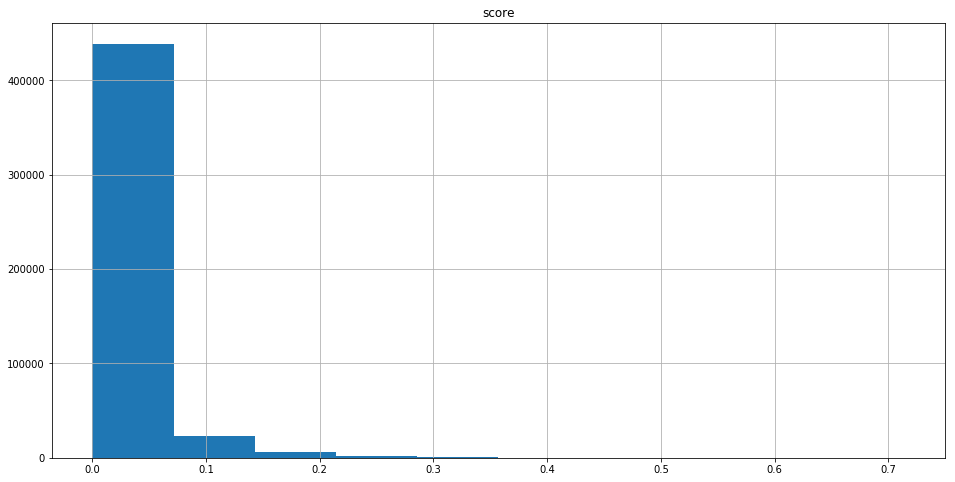

In [18]:
visData.hist("score")

In [4]:
visData.describe()

,score
count,4.701800e+05
mean,1.636435e-02
std,3.633586e-02
min,2.102670e-10
25%,5.180060e-04
50%,3.240795e-03
75%,1.271420e-02
max,7.139310e-01


In [5]:
bigger_than_point_one = visData[visData["score"]>0.1]
len(bigger_than_point_one)

18603

In [6]:
debug_dict = preprocess.create_paper_paper_dict(datadir="../dblp-ref",debug=True)

In [7]:
def filter_0_or_more(data_dict):
  # papers which cite 0 paper is useless. remove from data.
    count0_list = []
    for key, value in data_dict.items():
        if len(value) == 0:
            count0_list.append(key)
    for each in count0_list:
        del data_dict[each]
    return count0_list, data_dict

count0_list, rest_dict = filter_0_or_more(debug_dict)
len(rest_dict)

47018

In [ ]:
# You can use the entire training data by this:
!export OPENBLAS_NUM_THREADS=1
!export MKL_NUM_THREADS=1
start(inputfile='../dblp-ref/aminer-full.tsv',outputfile='../output-full.tsv')